In [1]:
import os
import numpy as np
import pandas as pd
import umap
import time
from Bio import SeqIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Patch
os.chdir('/biodata/franco/zsuzsa_lab/jupyter')
import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'mono', fontsize = 20, colors = 'banskt', dpi = 300)


In [3]:
import collections

disprot_regions_dict = collections.defaultdict(dict)
disprot_dict = collections.defaultdict(dict)
with open("/biodata/franco/datasets/disprot/disprot_regions_seq_2023_12_Structure_namespaces_CDHIT_1.0_OK.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
        unip = record.id.split('|')[0]
        disprot_regions_dict[unip]['seq'] = str(record.seq)
with open("/biodata/franco/datasets/disprot/disprot_regions_annot_2023_12_Structure_namespaces_CDHIT_1.0_OK.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
        unip = record.id.split('|')[0]
        disprot_regions_dict[unip]['disorder'] = str(record.seq)


with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
        disprot_dict[record.id]['seq'] = str(record.seq)
with open("/biodata/franco/datasets/disprot/disprot_OK_fullset_annotations_2023_12.fasta") as instrm:
    for record in SeqIO.parse(instrm, "fasta"):
        disprot_dict[record.id]['disorder'] = str(record.seq)

In [8]:
## Load secondary structure into 'disprot_dict', then from this obtain ss_regions, that should be put into disprot_regions_dict
## or perhaps in another dictionary to have them separately
## ss regions should be defined somehow. I'd say at least 5aa to call it a "region", consider H, B, HB, U and M ss residues.
import copy
import json

def load_secondary_structure(protein_dict):
    complete_counter = 0
    incomplete_counter = 0
    none_counter = 0
    nofile_counter = 0
    complete_label = "consensus_0.75"
    incomplete_label = "consensus_0.75_inc"

    new_protein_dict = copy.deepcopy(protein_dict)

    for uniprot_id in protein_dict:
        #print(uniprot_id)
        ss_file = f"mobidb_dev_10_2024_SSannotated/consensus/{uniprot_id}_consensus.json"
        fullpdb_file = f"mobidb_dev_10_2024_SSannotated/{uniprot_id}.json"
        if os.path.exists(ss_file):
            with open(ss_file) as f:
                ss_data_dict = json.load(f)
            with open(fullpdb_file) as f:
                pdb_data_dict = json.load(f)
            if pdb_data_dict[uniprot_id]['stats']['complete'] > 0:
                # get complete
                ss_seq = ss_data_dict[uniprot_id][complete_label]
                complete_counter += 1
            elif pdb_data_dict[uniprot_id]['stats']['incomplete'] > 0:
                # get incomplete
                ss_seq = ss_data_dict[uniprot_id][incomplete_label]
                incomplete_counter += 1
            else:
                # get any, they should all be "-"
                ss_seq = ss_data_dict[uniprot_id][complete_label]
                none_counter += 1
        else:
            # print(f"{ss_file} json file does not exist")
            nofile_counter += 1
            ss_seq = "".join(["-" for i in range(len(protein_dict[uniprot_id]['seq']))])
        new_protein_dict[uniprot_id]['ss'] = ss_seq
        if len(new_protein_dict[uniprot_id]['ss']) != len(new_protein_dict[uniprot_id]['seq']):
            raise

    print(f"complete:{complete_counter}, incomplete:{incomplete_counter}, nodata:{none_counter}, nofile:{nofile_counter}")
    return new_protein_dict

disprot_dict = load_secondary_structure(disprot_dict)

complete:669, incomplete:1065, nodata:355, nofile:433


In [31]:
disprot_ss_regions = collections.defaultdict(dict)
counter = 0
regions = dict()
regions["H"] = list()
regions["B"] = list()
regions["U"] = list()
regions["M"] = list()

for uniprot_id in disprot_dict:
    seq = disprot_dict[uniprot_id]['seq']
    ss  = disprot_dict[uniprot_id]['ss']
    #print(ss)
    preregions = ss.split("-")
    ix_counter = 0
    region_counter = 0
    for region in preregions:
        if len(region) >= 5:
            #print(region)
            if len(set(list(region))) == 1:
                if region.startswith("H"):
                    regions["H"].append(region)
                if region.startswith("B"):
                    regions["B"].append(region)
                if region.startswith("U"):
                    regions["U"].append(region)
                if region.startswith("M"):
                    regions["M"].append(region)
                region_id = uniprot_id + "_" + str(region_counter) + "_" + str(ix_counter) + "_" + str(ix_counter+len(region))
                disprot_ss_regions[region_id]['seq'] = seq[ix_counter:ix_counter+len(region)]
                disprot_ss_regions[region_id]['ss'] = region
                ix_counter += len(region)+1
                region_counter += 1
            else:
                # Region could be a combination of several letters.. complicated
                #print(region)
                multi_regions = []
                this_aa = None
                this_region = []
                for aa in region:
                    if len(this_region) == 0:
                        this_region.append(aa)
                    else:
                        if aa == this_region[-1]:
                            this_region.append(aa)
                        else:
                            # change of region
                            multi_regions.append("".join(this_region))
                            this_region = []
                            this_region.append(aa)
                multi_regions.append("".join(this_region))
                #print(multi_regions)
                for sub_region in multi_regions:
                    if len(sub_region) >= 5:
                        #print(sub_region)
                        if len(set(list(sub_region))) == 1:
                            if sub_region.startswith("H"):
                                regions["H"].append(sub_region)
                            if sub_region.startswith("B"):
                                regions["B"].append(sub_region)
                            if sub_region.startswith("U"):
                                regions["U"].append(sub_region)
                            if sub_region.startswith("M"):
                                regions["M"].append(sub_region)
                            region_id = uniprot_id + "_" + str(region_counter) + "_" + str(ix_counter) + "_" + str(ix_counter+len(sub_region))
                            disprot_ss_regions[region_id]['seq'] = seq[ix_counter:ix_counter+len(sub_region)]
                            disprot_ss_regions[region_id]['ss'] = sub_region
                            ix_counter += len(sub_region)
                            region_counter += 1
                        else:
                            print("SOME WEIRD MULTI REGION ERROR?")
                            print(sub_region, multi_regions)
                            raise
                    else:
                        ix_counter += len(sub_region)


            # print(seq[ix_counter:ix_counter+len(region)])
            # print(region)
            # region_id = uniprot_id + "_" + str(region_counter) + "_" + str(ix_counter) + "_" + str(ix_counter+len(region))
            # disprot_ss_regions[region_id]['seq'] = seq[ix_counter:ix_counter+len(region)]
            # disprot_ss_regions[region_id]['ss'] = region
            # ix_counter += len(region)+1
            # region_counter += 1
        else:
            ix_counter += len(region)+1

In [35]:
# ## ALL GOOD!!
# target = "Q08209"
# print(disprot_dict[target]['seq'])
# print(len(disprot_dict[target]['seq']))
# print(disprot_dict[target]['ss'])
# print("=====")
# for d in disprot_ss_regions:
#     if d.startswith(target):
#         print(d) 
#         print(disprot_ss_regions[d]['seq'])
#         print(disprot_ss_regions[d]['ss'])
#         print("=====")

## dump into a fasta for calculations

with open("../disprot_OK_ss_regions_2023_12.fasta", 'w') as outstream:
    for d in disprot_ss_regions:
        outstream.write(f">{d}\n{disprot_ss_regions[d]['seq']}\n")


with open("../disprot_OK_ss_regions_annotations_2023_12.fasta", 'w') as outstream:
    for d in disprot_ss_regions:
        outstream.write(f">{d}\n{disprot_ss_regions[d]['ss']}\n")

In [3]:
## Takes like 20min to calculate, better load it!!

calculate = False

if calculate:
    embedding_dir = "../disprot_2023_12_embeddings/halft5"
    embedding_matrix = None
    sequence_concat = ""
    disorder_concat = ""
    counter = 0
    for unip in disprot_regions_dict:
        # read embedding file
        embedding_file = os.path.join(embedding_dir, unip + ".npy")
        if not os.path.exists(embedding_file):
            raise
        if embedding_matrix is None:
            embedding_matrix = np.load(embedding_file)
        else:
            # stack the embedding matrix
            embedding_matrix = np.vstack((embedding_matrix, np.load(embedding_file)))
        # concatenate the sequences
        sequence_concat += disprot_regions_dict[unip]['seq']
        disorder_concat += disprot_regions_dict[unip]['disorder']
        counter += 1

    # save the compiled and concatenated data
    concat_order = []
    for unip in disprot_regions_dict:
        concat_order.append(f"{unip}\t{len(disprot_regions_dict[unip]['seq'])}")
        
    np.save("disprot_regions_embedding_matrix.npy", embedding_matrix)
    with open("disprot_regions_sequences_and_annots_concat.txt", "w") as outstrm:
        outstrm.write(f"{sequence_concat}\n")
        outstrm.write(f"{disorder_concat}\n")
        for e in concat_order:
            outstrm.write(f"{e}\n")
    import umap

    # create umap plot
    my_umap = umap.UMAP(n_neighbors=200, min_dist=.25) # metric='cosine'
    umap_embedding = my_umap.fit_transform(embedding_matrix)

    # save umap embedding
    umap_embedding_file = os.path.join(embedding_dir, "disprot_regions_AA_umap_200_0.25.npy")
    np.save(umap_embedding_file, umap_embedding)
else:
    # Load UMAP embedding matrix
    sequence_concat = ""
    disorder_concat = ""
    counter = 0
    for unip in disprot_regions_dict:
        # concatenate the sequences
        sequence_concat += disprot_regions_dict[unip]['seq']
        disorder_concat += disprot_regions_dict[unip]['disorder']

    embedding_dir = "../disprot_2023_12_embeddings/halft5"
    umap_embedding_file = os.path.join(embedding_dir, "disprot_regions_AA_umap_200_0.25.npy")
    umap_embedding = np.load(umap_embedding_file)

    # load T5 embedding matrix and the rest of the data
    embedding_matrix = np.load("disprot_regions_embedding_matrix.npy")
    with open("disprot_regions_sequences_and_annots_concat.txt") as instrm:
        sequence_concat = instrm.readline().strip()
        disorder_concat = instrm.readline().strip()
        concat_order = [x.strip().split() for x in instrm.readlines()]

In [4]:
# from matplotlib import cm
# from matplotlib.patches import Patch

# AAs = list(set(sequence_concat))
# cmapAA = cm.get_cmap('gist_rainbow', len(AAs))
# colordictAA = dict(zip(AAs, np.arange(0, len(AAs))))

# fig = plt.figure(figsize=(14,6), dpi=300)
# ax1  = fig.add_subplot(121)
# ax2  = fig.add_subplot(122)

# ax1.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.5, alpha=0.1, marker=',', c=[cmapAA(colordictAA[x]) for x in sequence_concat])

# #legend_elements = [Patch(facecolor=cmapAA(colordictAA[x]), edgecolor=cmapAA(colordictAA[x]),label=x) for x in AAs]
# #ax1.legend(handles=legend_elements, loc='right')

# DDs = list(set(disorder_concat))
# cmapDD = cm.get_cmap('gist_rainbow', len(DDs))
# colordictDD = dict(zip(DDs, np.arange(0, len(DDs))))
# ax2.scatter(umap_embedding[:,0], umap_embedding[:,1], s=0.5, alpha=0.1, marker=',', c=[cmapDD(colordictDD[x]) for x in disorder_concat])
# legend_elements = [Patch(facecolor=cmapDD(colordictDD[x]), edgecolor=cmapDD(colordictDD[x]),label=x) for x in DDs]
# ax2.legend(handles=legend_elements, loc='right')

# fig.suptitle("Aminoacid embeddings for IDRs without context")
# fig.tight_layout()
# plt.show()

In [5]:
# import plotly.express as px


# AAs = list(sequence_concat)
# DDs = list(disorder_concat)
# df = pd.DataFrame({'UMAP1': umap_embedding[:,0], 'UMAP2': umap_embedding[:,1], 'AA': AAs, 'DD': DDs})

# fig = px.scatter(df, x='UMAP1', y='UMAP2', color='DD', hover_data=['AA', 'DD'], width=900, height=800)
# fig.update_traces(marker_size=3, marker=dict(opacity=0.5))
# fig.show()


In [6]:
# from matplotlib import cm
# from matplotlib.patches import Patch

# ## select only a single aminoacid
aa_target = "Y"
indexes = np.array([i for i,aa in enumerate(sequence_concat) if aa == aa_target])
crop_umap_emb = umap_embedding[indexes,:]

# DDs = list(set([disorder_concat[i] for i in indexes]))
# cmapDD = cm.get_cmap('gist_rainbow', len(DDs))
# colordictDD = dict(zip(DDs, np.arange(0, len(DDs))))

# aa_disorder = [disorder_concat[i] for i in indexes]
# fig = plt.figure(figsize=(11,11), dpi=72)
# for i in range(len(DDs)):
#     print(DDs[i])
#     diso_index = np.array([k for k,dd in enumerate(aa_disorder) if dd == DDs[i]])
#     ax = fig.add_subplot(2,2,i+1)
#     ax.scatter(crop_umap_emb[diso_index,0], crop_umap_emb[diso_index,1], s=1, alpha=0.1, c=[cmapDD(colordictDD[x]) for x in [aa_disorder[j] for j in diso_index]])
#     legend_elements = [Patch(facecolor=cmapDD(colordictDD[DDs[i]]), edgecolor=cmapDD(colordictDD[DDs[i]]),label=DDs[i])]
#     ax.legend(handles=legend_elements, loc='right')
#     ax.set_xlim(-9,12)
#     ax.set_ylim(-13,18)

# fig.suptitle(f"Aminoacid={aa_target} embeddings in IDRs without context")
# fig.tight_layout()
# plt.show()

In [7]:
# from the t5_embedding matrix, select only a single aminoacid type and re-do the UMAP embedding
aa_target = "Y"
indexes = np.array([i for i,aa in enumerate(sequence_concat) if aa == aa_target])

embedding_matrix_target = embedding_matrix[indexes,:]
my_umap = umap.UMAP(n_neighbors=200, min_dist=.25) # metric='cosine'
umap_embedding_target = my_umap.fit_transform(embedding_matrix_target)


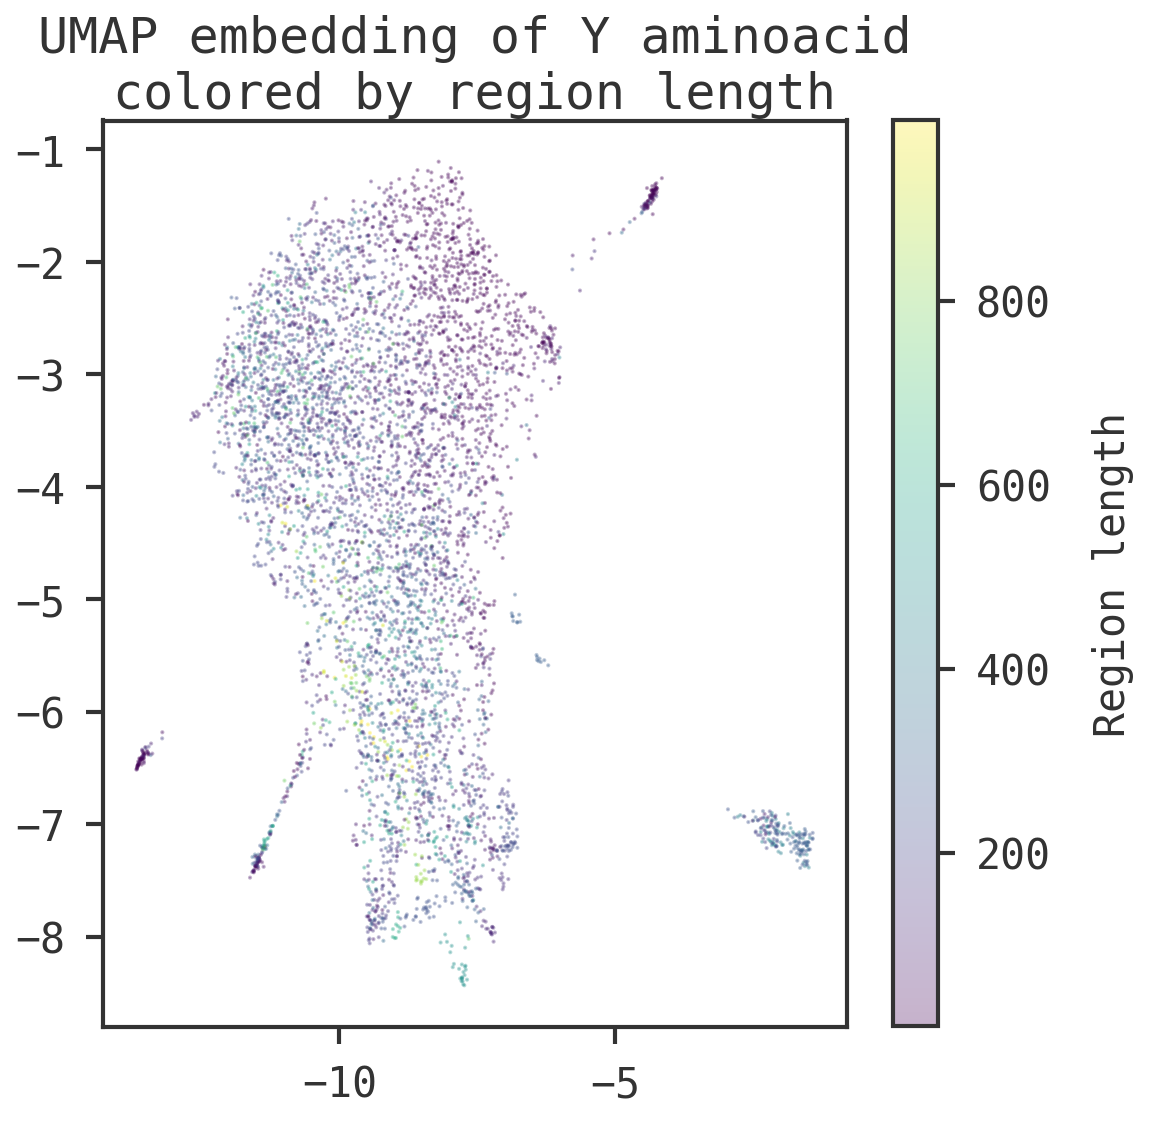

In [8]:
regions_ids = []
R_lengths = []
for r in concat_order:
    length = int(r[1])
    regions_ids.append(r[0])
    R_lengths.append(length)

# expand R_lengths
all_Rlengths = []
for l in R_lengths:
    all_Rlengths += [l for i in range(l)]

# use R_lengths to get distance to begining of end of the sequence
all_distRlengths = []
for l in R_lengths:
    for i in range(l):
        halfway_point = l/2
        if i < halfway_point:
            dist = i
        else:
            dist = l - i
        all_distRlengths += [dist]

target_Rlengths = [all_Rlengths[i] for i in indexes]
target_distRlengths = [all_distRlengths[i] for i in indexes]

# create umap plot
fig = plt.figure(figsize=(8,8), dpi=150)
ax1  = fig.add_subplot(111)
# ax2  = fig.add_subplot(122)

c = ax1.scatter(umap_embedding_target[:,0], umap_embedding_target[:,1], s=1, alpha=0.3, marker='o', c=target_Rlengths)
cbar = fig.colorbar(c, ax=ax1)
cbar.set_label('Region length')
ax1.set_title(f"UMAP embedding of {aa_target} aminoacid\ncolored by region length")

# c2 = ax2.scatter(umap_embedding_target[:,0], umap_embedding_target[:,1], s=1, alpha=0.3, marker='o', c=target_distRlengths)
# cbar = fig.colorbar(c2, ax=ax2)
# cbar.set_label('Distance to C or N terminal')
# ax2.set_title(f"UMAP embedding of {aa_target} aminoacid\ncolored by region length")


plt.show()

In [9]:
R_lengths = []
regions_ids = []
for r in concat_order:
    length = int(r[1])
    regions_ids.append(r[0])
    R_lengths.append(length)

# expand region ids
all_region_ids = []
for i,r in enumerate(regions_ids):
    all_region_ids += [r for i in range(R_lengths[i])]

# expand R_lengths
all_Rlengths = []
for l in R_lengths:
    all_Rlengths += [l for i in range(l)]

# use R_lengths to get distance to begining of end of the sequence
all_distRlengths = []
for l in R_lengths:
    for i in range(l):
        halfway_point = l/2
        if i < halfway_point:
            dist = i
        else:
            dist = l - i
        all_distRlengths += [dist]


target_Rlengths = [all_Rlengths[i] for i in indexes]
target_distRlengths = [all_distRlengths[i] for i in indexes]
target_region_ids = [all_region_ids[i] for i in indexes]

# create umap plot using plotly
import plotly.express as px

df = pd.DataFrame(umap_embedding_target, columns=['UMAP1', 'UMAP2'])
df['Rlength'] = target_Rlengths
df['distRlength'] = target_distRlengths
df['aa'] = aa_target
df['region_id'] = target_region_ids
df['dummy_column_for_size'] = 1

#fig = px.scatter(df, x='x', y='y', color='Rlength', size='distRlength', hover_data=['region_id'])
fig = px.scatter(df, x='UMAP1', y='UMAP2', color='distRlength', hover_data=['region_id'], size='distRlength', width=900, height=800,
                labels={
                    "distRlength": "Distance to \nN/C-terminal",
                 },
                 range_color=[0,300])
fig.update_layout(title=f"UMAP embedding of {aa_target} aminoacid, color and size by distance to N/C-terminal")
fig.update_traces(marker=dict(opacity=0.5, line=dict(color='DarkSlateGrey', width=0.5)))

## add text to outliers using their (x,y) coordinates:
len2annotate = [0, 1, 2, 3]
annotate_df = pd.DataFrame([])
for l in len2annotate:
    annotate_df = pd.concat([annotate_df, df[df['distRlength'] == l].sample(1)])

## add text to outliers using their (x,y) coordinates:
prev_coord = annotate_df.iloc[0][['UMAP1', 'UMAP2']].values
yshift = 10
xshift = 0
for r in annotate_df.itertuples(index=False):
    x = r.UMAP1
    y = r.UMAP2
    if abs(x - prev_coord[0]) < 2.5 and abs(y - prev_coord[1]) < 2.5:
        yshift = yshift * -1
    fig.add_annotation(
        x=x, y=y,
        text=f"{r.distRlength}",
        showarrow=False,
        yshift=yshift,
        xshift=xshift,
        font=dict(
        family="sans serif",
        size=18,
        color="red")
    )
    prev_coord = [x,y]

fig.write_image(f"plots/umap_{aa_target}_size_color_dist2terminal.png", engine='kaleido')
fig.show()


In [10]:
df[df['distRlength'] == l].head(1)

UMAP1     UMAP2  Rlength  distRlength aa           region_id  \
84 -7.916803 -6.130768       62            3  Y  P15340_DP00057r001   

    dummy_column_for_size  
84                      1

In [11]:
# get protein-level embedding and stack them in a new matrix
acum = 0
lengths = []
protlevel_emb_matrix = None
regions_ids = []
for r in concat_order:
    length = int(r[1])
    regions_ids.append(r[0])
    lengths.append(length)
    protemb = np.mean(embedding_matrix[acum:acum+length], axis=0)
    acum += length
    if protlevel_emb_matrix is None:
        protlevel_emb_matrix = protemb
    else:
        protlevel_emb_matrix = np.vstack((protlevel_emb_matrix, protemb))

In [12]:
print(protlevel_emb_matrix.shape)

# make histogram of lengths
plt.figure(figsize=(6,6), dpi=72)
plt.hist(lengths, bins=range(1,70))
plt.title("Histogram of region lengths")
plt.show()


(4101, 1024)


In [13]:
# plot umap embedding of the matrix

my_umap = umap.UMAP(n_neighbors=200, min_dist=.25) # metric='cosine'
protlevel_umap_emb = my_umap.fit_transform(protlevel_emb_matrix)

In [14]:
import plotly.express as px

df = pd.DataFrame(protlevel_umap_emb, columns=['UMAP1', 'UMAP2'])
df['regions'] = regions_ids
df['length'] = lengths

fig = px.scatter(df, x='UMAP1', y='UMAP2', color='length', hover_data=['regions'], width=700, height=700, 
                 labels={'length':"Region length"}, title="UMAP of disordered regions",
                 size='length',
                 range_color=[0,300])
fig.update_traces(marker=dict(opacity=0.5, line=dict(color='DarkSlateGrey', width=0.5)))
fig.update_traces(textposition='top center')

len2annotate = [13, 14, 15, 16, 17, 18, 19, 20, 23, 25, 30, 31, 
                40, 41, 43, 45, 
                50, 52, 54, 55, 
                60, 70, 80, 90, 100,
                110, 120, 130, 140, 150,
                200, 250, 300, 350]
## add text to outliers using their (x,y) coordinates:
annotate_df = pd.DataFrame([])
for l in len2annotate:
    annotate_df = pd.concat([annotate_df, df[df['length'] == l].sample(1)])

## add text to outliers using their (x,y) coordinates:
prev_coord = [0,0]
yshift = 10
xshift = 0
for r in annotate_df.itertuples(index=False):
    x = r.UMAP1
    y = r.UMAP2
    if abs(x - prev_coord[0]) < 2.5 and abs(y - prev_coord[1]) < 2.5:
        yshift = yshift * -1
    fig.add_annotation(
        x=x, y=y,
        text=f"{r.length}",
        showarrow=False,
        yshift=yshift,
        xshift=xshift
    )
    prev_coord = [x,y]


fig.write_image(f"plots/umap_IDRs_size_color_length.png", engine='kaleido')
fig.show()

In [15]:
r.UMAP1

13.82249641418457

In [16]:
# Find the in-context regions on each embedding, make the same matrix as before, but with these in-context regions

disprot_regions_file = "/biodata/franco/datasets/disprot/DisProt_release_2023_12_with_ambiguous_evidences.tsv"
df = pd.read_table(disprot_regions_file, header=0)

# parse table into region ids and keep start and end
annot_dict = {}
for i, row in df.iterrows():
    region_id  = f"{row['acc']}_{row['region_id']}"
    if region_id not in annot_dict:
        annot_dict[region_id] = [row['start'], row['end']]

calculate = False
if calculate:
    outcontext_matrix_embeddings = None
    incontext_matrix_embeddings  = None
    for unip_R in regions_ids:
        target, region_id = unip_R.split("_")
        #print(target, region_id)

        if 'seq' in disprot_dict[target]:
            seq  = disprot_dict[target]['seq']
            diso = disprot_dict[target]['disorder']
            embedding_file = os.path.join(embedding_dir, target + ".npy")
            #print(embedding_file)
            target_embedding = np.load(embedding_file)

            ## find target regions
            target_regions = [k for k in disprot_regions_dict if k == unip_R]
            assert len(target_regions) == 1
            ## need to load region embedding again, because some regions are from very long sequences not present in the other set of embeddings
            region_embedding_file = os.path.join(embedding_dir, unip_R+".npy")
            region_embedding = np.load(region_embedding_file)
            #print(region_embedding.shape)

            # get the target region in the embedding
            for t in target_regions:
                #print(t, annot_dict[t])
                start, end = annot_dict[t]
                assert disprot_regions_dict[t]['seq'] == disprot_dict[target]['seq'][start-1:end]
                if outcontext_matrix_embeddings is None:
                    outcontext_matrix_embeddings = region_embedding
                else:
                    outcontext_matrix_embeddings = np.vstack((outcontext_matrix_embeddings, region_embedding))
                if incontext_matrix_embeddings is None:
                    incontext_matrix_embeddings = target_embedding[start-1:end]
                else:
                    incontext_matrix_embeddings = np.vstack((incontext_matrix_embeddings, target_embedding[start-1:end]))

    # save both matrices
    # IDR region embeddings, calculated for the whole protein, then cut out from it
    np.save("disprot_regions_incontext_embedding_matrix.npy", incontext_matrix_embeddings)
    # IDR region embeddings, calculated from the regione sequence, without the 'ordered' sequence context
    np.save("disprot_regions_outcontext_embedding_matrix.npy", outcontext_matrix_embeddings)
else:
    incontext_matrix_embeddings = np.load("disprot_regions_incontext_embedding_matrix.npy")
    outcontext_matrix_embeddings = np.load("disprot_regions_outcontext_embedding_matrix.npy")

In [17]:
incontext_region_data = []
outcontext_sequence_concat = ""
for unip_R in regions_ids:
    target, region_id = unip_R.split("_")

    if 'seq' in disprot_dict[target]:
        seq  = disprot_dict[target]['seq']
        diso = disprot_dict[target]['disorder'] 
        ## find target regions
        target_regions = [k for k in disprot_regions_dict if k == unip_R]
        assert len(target_regions) == 1
        ## need to load region embedding again, because some regions are from very long sequences not present in the other set of embeddings
        # get the target region start and end
        for t in target_regions:
            start, end = annot_dict[t]
            assert disprot_regions_dict[t]['seq'] == disprot_dict[target]['seq'][start-1:end]
            outcontext_sequence_concat += disprot_dict[target]['seq'][start-1:end]
            incontext_region_data.append([unip_R, len(disprot_dict[target]['seq'][start-1:end])])


In [18]:
print(incontext_matrix_embeddings.shape)
print(outcontext_matrix_embeddings.shape)
print(len(outcontext_sequence_concat))

# ## select only a single aminoacid
# aa_target = "R"
# indexes = np.array([i for i,aa in enumerate(outcontext_sequence_concat) if aa == aa_target])

from scipy.spatial.distance import cosine
from scipy.spatial.distance import euclidean

cos_distances = []
euc_distances = []
for i in range(incontext_matrix_embeddings.shape[0]):

    # Calculate cosine distance
    dist = cosine(incontext_matrix_embeddings[i,:], outcontext_matrix_embeddings[i,:])
    euc  = euclidean(incontext_matrix_embeddings[i,:], outcontext_matrix_embeddings[i,:])
    cos_distances.append(dist)
    euc_distances.append(euc)
cos_distances = np.array(cos_distances)
euc_distances = np.array(euc_distances)

(214077, 1024)
(214077, 1024)
214077


In [19]:
# make a histogram of the cos_distances
plt.figure(figsize=(6,6), dpi=72)
plt.hist(cos_distances)
plt.show()

plt.figure(figsize=(6,6), dpi=72)
plt.hist(euc_distances)
plt.show()

In [20]:
# get the region from which the AA was taken, relative to region length
aa_reg_relativelen = []
aa_reg_len = []
rids_concat = []
coverages = []

regions_len_coverage = {}
for unip_R in regions_ids:
    target, region_id = unip_R.split("_")

    if 'seq' in disprot_dict[target]:
        seq  = disprot_dict[target]['seq']
        len_coverage = len(disprot_regions_dict[unip_R]['seq'])/ len(disprot_dict[target]['seq'])
        regions_len_coverage[unip_R] = len_coverage


for rid, length in incontext_region_data:
    aa_reg_relativelen += [float(i)/length for i in range(length)]
    aa_reg_len += [length for i in range(length)]
    rids_concat += [rid for i in range(length)]
    coverages += [regions_len_coverage[rid] for i in range(length)]

aa_reg_relativelen = np.array(aa_reg_relativelen)

# make a list with aminoacid type
aas = [aa for aa in outcontext_sequence_concat]

df = pd.DataFrame({'rid':rids_concat, 'aa_reg_len': aa_reg_len, 'coverage':coverages, 'aa_reg_relativelen': aa_reg_relativelen, 'euc_distances': euc_distances, 'cos_distances': cos_distances, "AA":aas})
df_nZ = df[df["AA"] != "Z"]

df.to_csv("disprot_outcontext_regions_distances_df.txt", sep="\t", header=True, index=False)

In [21]:
plt.figure(figsize=(6,6), dpi=72)
plt.hist(regions_len_coverage.values())
plt.show()